# Data Access

In [1]:
import numpy as np
import matplotlib.image as mpimg
import os
from os import listdir
from sklearn.datasets import load_files

from os.path import isfile, join
from random import sample
from tqdm.notebook import tqdm
from keras.utils.np_utils import to_categorical   
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
#read data
def load_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

In [90]:
#read data

data = 'C:/Users/Zhenkun/Desktop/GU/590/final_project/data'
x, y, labels = load_data(data)


In [91]:
#split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


In [92]:
labels

array(['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS',
       'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN',
       'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA',
       'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN',
       'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING',
       'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAR-TAILED GODWIT', 'BARN OWL',
       'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER',
       'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE',
       'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN',
       'BLACK THROATED WARBLER', 'BLACK VULTURE',
       'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE',
       'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE',
       'BLUE HERON', 'BOBOLINK', 'BROWN NOODY', 'BROWN THRASHER',
       'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL',
       'CALIFORNIA QUAIL', 'CANARY', 'CAPE MAY WARBLER'

In [95]:
# change type
def image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [96]:
X_train = np.array(image_to_array(X_train))
X_valid = np.array(image_to_array(X_valid))
X_test = np.array(image_to_array(X_test))

In [97]:

X_train=np.asarray(X_train).astype('float32')/255
y_train=np.asarray(y_train).reshape(-1,1)
y_train_cat = to_categorical(y_train, num_classes=230)
print((X_train.shape,y_train_cat.shape))

((21968, 224, 224, 3), (21968, 230))


In [98]:
X_test = np.asarray(X_test).astype('float32')/255
y_test = np.asarray(y_test).reshape(-1,1)
y_test_cat = to_categorical(y_test, num_classes=230)
print((X_test.shape,y_test_cat.shape))

((6865, 224, 224, 3), (6865, 230))


In [99]:
X_valid = np.asarray(X_valid).astype('float32')/255
y_valid = np.asarray(y_valid).reshape(-1,1)
y_valid_cat = to_categorical(y_valid, num_classes=230)
print((X_valid.shape,y_valid_cat.shape))

((5492, 224, 224, 3), (5492, 230))


# VGG19


In [186]:
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import TensorBoard
import tensorflow
import tensorflow.keras as tfk
from keras.callbacks import ModelCheckpoint, EarlyStopping

tfkl = tfk.layers



In [185]:
# add data augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
valid_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

train_generator.fit(X_train)
test_generator.fit(X_test)
valid_generator.fit(X_valid)

In [187]:
# use vgg19 model
base_model=VGG19(include_top=False, weights = 'imagenet', input_shape = (224,224,3), classes = y_test_cat.shape[1])

In [188]:
#add layers and compile model
VGG19 = tfk.Sequential()

VGG19.add(base_model)
for layer in VGG19.layers:
    layer.trainable = False
VGG19.add(tfkl.GlobalMaxPooling2D())
VGG19.add(tfkl.Dense(230,activation=('softmax')))
VGG19.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
VGG19.summary()


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 230)               117990    
Total params: 20,142,374
Trainable params: 117,990
Non-trainable params: 20,024,384
_________________________________________________________________


In [190]:
#add early stop and train model
Early_sp = EarlyStopping(monitor = 'val_accuracy', patience = 3,restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

VGG19_results=VGG19.fit(X_train, y_train_cat,
                        batch_size=64 ,
                        epochs =100,
                        validation_data=(X_valid, y_valid_cat),
                        callbacks = [Early_sp,reduce_lr])
VGG19.save('VGG_model')                 

Train on 21968 samples, validate on 5492 samples
Epoch 1/100


11776/21968 [===============>..............] - ETA: 4:51 - loss: 5.4386 - accuracy: 0.0000e+ - ETA: 3:02 - loss: 5.4378 - accuracy: 0.0078   - ETA: 2:25 - loss: 5.4380 - accuracy: 0.00 - ETA: 2:06 - loss: 5.4382 - accuracy: 0.00 - ETA: 1:55 - loss: 5.4384 - accuracy: 0.00 - ETA: 1:47 - loss: 5.4375 - accuracy: 0.00 - ETA: 1:42 - loss: 5.4378 - accuracy: 0.00 - ETA: 1:37 - loss: 5.4378 - accuracy: 0.00 - ETA: 1:34 - loss: 5.4379 - accuracy: 0.00 - ETA: 1:32 - loss: 5.4379 - accuracy: 0.00 - ETA: 1:29 - loss: 5.4379 - accuracy: 0.00 - ETA: 1:27 - loss: 5.4375 - accuracy: 0.00 - ETA: 1:26 - loss: 5.4375 - accuracy: 0.00 - ETA: 1:24 - loss: 5.4378 - accuracy: 0.00 - ETA: 1:23 - loss: 5.4376 - accuracy: 0.00 - ETA: 1:22 - loss: 5.4374 - accuracy: 0.00 - ETA: 1:21 - loss: 5.4373 - accuracy: 0.00 - ETA: 1:20 - loss: 5.4374 - accuracy: 0.00 - ETA: 1:19 - loss: 5.4368 - accuracy: 0.00 - ETA: 1:18 - loss: 5.4369 - accuracy: 0.00 - ETA: 1:18 - loss: 5.4368 - accuracy: 0.00 - ETA: 1:17 - loss: 5.4

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.4179 - accuracy: 0.03 - ETA: 1:13 - loss: 5.4301 - accuracy: 0.01 - ETA: 1:13 - loss: 5.4264 - accuracy: 0.02 - ETA: 1:12 - loss: 5.4111 - accuracy: 0.04 - ETA: 1:12 - loss: 5.4077 - accuracy: 0.05 - ETA: 1:12 - loss: 5.3983 - accuracy: 0.06 - ETA: 1:12 - loss: 5.3965 - accuracy: 0.06 - ETA: 1:11 - loss: 5.3949 - accuracy: 0.06 - ETA: 1:11 - loss: 5.3977 - accuracy: 0.06 - ETA: 1:11 - loss: 5.3910 - accuracy: 0.07 - ETA: 1:11 - loss: 5.3886 - accuracy: 0.07 - ETA: 1:11 - loss: 5.3868 - accuracy: 0.07 - ETA: 1:10 - loss: 5.3854 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3847 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3848 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3832 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3836 - accuracy: 0.08 - ETA: 1:09 - loss: 5.3839 - accuracy: 0.08 - ETA: 1:09 - loss: 5.3860 - accuracy: 0.07 - ETA: 1:09 - loss: 5.3866 - accuracy: 0.07 - ETA: 1:09 - loss: 5.3864 - accuracy: 0.07 - ETA: 1:09 - loss: 5.3878 - ac

21968/21968 [==============================] - ETA: 33s - loss: 5.3800 - accuracy: 0.080 - ETA: 33s - loss: 5.3799 - accuracy: 0.080 - ETA: 33s - loss: 5.3799 - accuracy: 0.080 - ETA: 32s - loss: 5.3799 - accuracy: 0.080 - ETA: 32s - loss: 5.3798 - accuracy: 0.080 - ETA: 32s - loss: 5.3795 - accuracy: 0.080 - ETA: 32s - loss: 5.3795 - accuracy: 0.081 - ETA: 32s - loss: 5.3794 - accuracy: 0.081 - ETA: 31s - loss: 5.3794 - accuracy: 0.081 - ETA: 31s - loss: 5.3793 - accuracy: 0.081 - ETA: 31s - loss: 5.3795 - accuracy: 0.081 - ETA: 31s - loss: 5.3796 - accuracy: 0.080 - ETA: 30s - loss: 5.3795 - accuracy: 0.080 - ETA: 30s - loss: 5.3796 - accuracy: 0.080 - ETA: 30s - loss: 5.3795 - accuracy: 0.080 - ETA: 30s - loss: 5.3797 - accuracy: 0.080 - ETA: 30s - loss: 5.3796 - accuracy: 0.080 - ETA: 29s - loss: 5.3795 - accuracy: 0.081 - ETA: 29s - loss: 5.3794 - accuracy: 0.081 - ETA: 29s - loss: 5.3794 - accuracy: 0.080 - ETA: 29s - loss: 5.3794 - accuracy: 0.080 - ETA: 29s - loss: 5.3793 - acc

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3810 - accuracy: 0.09 - ETA: 1:13 - loss: 5.3777 - accuracy: 0.08 - ETA: 1:14 - loss: 5.3706 - accuracy: 0.09 - ETA: 1:14 - loss: 5.3680 - accuracy: 0.09 - ETA: 1:13 - loss: 5.3701 - accuracy: 0.09 - ETA: 1:13 - loss: 5.3664 - accuracy: 0.09 - ETA: 1:13 - loss: 5.3715 - accuracy: 0.09 - ETA: 1:12 - loss: 5.3679 - accuracy: 0.09 - ETA: 1:12 - loss: 5.3655 - accuracy: 0.09 - ETA: 1:12 - loss: 5.3663 - accuracy: 0.09 - ETA: 1:11 - loss: 5.3693 - accuracy: 0.08 - ETA: 1:12 - loss: 5.3710 - accuracy: 0.08 - ETA: 1:11 - loss: 5.3715 - accuracy: 0.08 - ETA: 1:11 - loss: 5.3695 - accuracy: 0.08 - ETA: 1:11 - loss: 5.3711 - accuracy: 0.08 - ETA: 1:11 - loss: 5.3735 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3751 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3748 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3761 - accuracy: 0.08 - ETA: 1:10 - loss: 5.3732 - accuracy: 0.08 - ETA: 1:09 - loss: 5.3738 - accuracy: 0.08 - ETA: 1:09 - loss: 5.3763 - ac

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3311 - accuracy: 0.14 - ETA: 1:13 - loss: 5.3568 - accuracy: 0.10 - ETA: 1:12 - loss: 5.3740 - accuracy: 0.08 - ETA: 1:12 - loss: 5.3515 - accuracy: 0.10 - ETA: 1:12 - loss: 5.3543 - accuracy: 0.10 - ETA: 1:12 - loss: 5.3604 - accuracy: 0.09 - ETA: 1:12 - loss: 5.3548 - accuracy: 0.10 - ETA: 1:12 - loss: 5.3557 - accuracy: 0.09 - ETA: 1:11 - loss: 5.3537 - accuracy: 0.10 - ETA: 1:11 - loss: 5.3577 - accuracy: 0.09 - ETA: 1:11 - loss: 5.3590 - accuracy: 0.09 - ETA: 1:11 - loss: 5.3601 - accuracy: 0.09 - ETA: 1:10 - loss: 5.3545 - accuracy: 0.10 - ETA: 1:10 - loss: 5.3535 - accuracy: 0.10 - ETA: 1:10 - loss: 5.3527 - accuracy: 0.10 - ETA: 1:10 - loss: 5.3519 - accuracy: 0.10 - ETA: 1:10 - loss: 5.3521 - accuracy: 0.10 - ETA: 1:09 - loss: 5.3519 - accuracy: 0.10 - ETA: 1:09 - loss: 5.3482 - accuracy: 0.10 - ETA: 1:09 - loss: 5.3480 - accuracy: 0.10 - ETA: 1:09 - loss: 5.3483 - accuracy: 0.10 - ETA: 1:09 - loss: 5.3477 - ac

21968/21968 [==============================] - ETA: 33s - loss: 5.3467 - accuracy: 0.111 - ETA: 33s - loss: 5.3467 - accuracy: 0.111 - ETA: 33s - loss: 5.3464 - accuracy: 0.111 - ETA: 33s - loss: 5.3462 - accuracy: 0.112 - ETA: 32s - loss: 5.3462 - accuracy: 0.112 - ETA: 32s - loss: 5.3463 - accuracy: 0.112 - ETA: 32s - loss: 5.3464 - accuracy: 0.111 - ETA: 32s - loss: 5.3463 - accuracy: 0.111 - ETA: 31s - loss: 5.3465 - accuracy: 0.111 - ETA: 31s - loss: 5.3460 - accuracy: 0.112 - ETA: 31s - loss: 5.3460 - accuracy: 0.112 - ETA: 31s - loss: 5.3459 - accuracy: 0.112 - ETA: 31s - loss: 5.3457 - accuracy: 0.112 - ETA: 30s - loss: 5.3460 - accuracy: 0.112 - ETA: 30s - loss: 5.3459 - accuracy: 0.112 - ETA: 30s - loss: 5.3458 - accuracy: 0.112 - ETA: 30s - loss: 5.3459 - accuracy: 0.112 - ETA: 29s - loss: 5.3459 - accuracy: 0.112 - ETA: 29s - loss: 5.3461 - accuracy: 0.112 - ETA: 29s - loss: 5.3463 - accuracy: 0.112 - ETA: 29s - loss: 5.3461 - accuracy: 0.112 - ETA: 29s - loss: 5.3458 - acc

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3442 - accuracy: 0.10 - ETA: 1:13 - loss: 5.3719 - accuracy: 0.07 - ETA: 1:12 - loss: 5.3555 - accuracy: 0.09 - ETA: 1:12 - loss: 5.3464 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3434 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3365 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3352 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3349 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3354 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3291 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3267 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3335 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3358 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3366 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3351 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3348 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3311 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3351 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3334 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3346 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3362 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3390 - ac

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3437 - accuracy: 0.10 - ETA: 1:13 - loss: 5.3406 - accuracy: 0.10 - ETA: 1:13 - loss: 5.3161 - accuracy: 0.13 - ETA: 1:12 - loss: 5.3332 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3324 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3363 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3256 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3279 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3292 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3296 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3320 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3291 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3328 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3308 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3320 - accuracy: 0.12 - ETA: 1:10 - loss: 5.3357 - accuracy: 0.11 - ETA: 1:10 - loss: 5.3315 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3293 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3297 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3282 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3286 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3301 - ac

21968/21968 [==============================] - ETA: 33s - loss: 5.3229 - accuracy: 0.133 - ETA: 33s - loss: 5.3233 - accuracy: 0.133 - ETA: 33s - loss: 5.3234 - accuracy: 0.133 - ETA: 33s - loss: 5.3234 - accuracy: 0.133 - ETA: 32s - loss: 5.3234 - accuracy: 0.133 - ETA: 32s - loss: 5.3234 - accuracy: 0.133 - ETA: 32s - loss: 5.3234 - accuracy: 0.133 - ETA: 32s - loss: 5.3233 - accuracy: 0.133 - ETA: 31s - loss: 5.3234 - accuracy: 0.133 - ETA: 31s - loss: 5.3239 - accuracy: 0.132 - ETA: 31s - loss: 5.3237 - accuracy: 0.133 - ETA: 31s - loss: 5.3234 - accuracy: 0.133 - ETA: 31s - loss: 5.3236 - accuracy: 0.133 - ETA: 30s - loss: 5.3239 - accuracy: 0.132 - ETA: 30s - loss: 5.3239 - accuracy: 0.132 - ETA: 30s - loss: 5.3240 - accuracy: 0.132 - ETA: 30s - loss: 5.3239 - accuracy: 0.132 - ETA: 30s - loss: 5.3242 - accuracy: 0.132 - ETA: 29s - loss: 5.3246 - accuracy: 0.132 - ETA: 29s - loss: 5.3245 - accuracy: 0.132 - ETA: 29s - loss: 5.3245 - accuracy: 0.132 - ETA: 29s - loss: 5.3246 - acc

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3143 - accuracy: 0.14 - ETA: 1:13 - loss: 5.2929 - accuracy: 0.17 - ETA: 1:13 - loss: 5.3238 - accuracy: 0.13 - ETA: 1:12 - loss: 5.3300 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3164 - accuracy: 0.14 - ETA: 1:12 - loss: 5.3188 - accuracy: 0.13 - ETA: 1:12 - loss: 5.3183 - accuracy: 0.13 - ETA: 1:12 - loss: 5.3188 - accuracy: 0.14 - ETA: 1:12 - loss: 5.3167 - accuracy: 0.14 - ETA: 1:11 - loss: 5.3204 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3284 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3277 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3274 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3257 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3227 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3204 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3226 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3211 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3199 - accuracy: 0.13 - ETA: 1:09 - loss: 5.3210 - accuracy: 0.13 - ETA: 1:09 - loss: 5.3212 - accuracy: 0.13 - ETA: 1:09 - loss: 5.3238 - ac

11904/21968 [===============>..............] - ETA: 1:14 - loss: 5.2828 - accuracy: 0.17 - ETA: 1:13 - loss: 5.3278 - accuracy: 0.11 - ETA: 1:13 - loss: 5.3463 - accuracy: 0.09 - ETA: 1:13 - loss: 5.3454 - accuracy: 0.10 - ETA: 1:13 - loss: 5.3385 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3398 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3385 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3368 - accuracy: 0.11 - ETA: 1:12 - loss: 5.3402 - accuracy: 0.11 - ETA: 1:11 - loss: 5.3365 - accuracy: 0.11 - ETA: 1:11 - loss: 5.3362 - accuracy: 0.11 - ETA: 1:11 - loss: 5.3256 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3260 - accuracy: 0.12 - ETA: 1:11 - loss: 5.3195 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3175 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3143 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3122 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3158 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3167 - accuracy: 0.13 - ETA: 1:09 - loss: 5.3134 - accuracy: 0.14 - ETA: 1:09 - loss: 5.3135 - accuracy: 0.14 - ETA: 1:09 - loss: 5.3138 - ac

21968/21968 [==============================] - ETA: 33s - loss: 5.3131 - accuracy: 0.142 - ETA: 33s - loss: 5.3132 - accuracy: 0.142 - ETA: 33s - loss: 5.3132 - accuracy: 0.142 - ETA: 33s - loss: 5.3135 - accuracy: 0.141 - ETA: 32s - loss: 5.3136 - accuracy: 0.141 - ETA: 32s - loss: 5.3137 - accuracy: 0.141 - ETA: 32s - loss: 5.3129 - accuracy: 0.142 - ETA: 32s - loss: 5.3132 - accuracy: 0.142 - ETA: 32s - loss: 5.3135 - accuracy: 0.141 - ETA: 31s - loss: 5.3135 - accuracy: 0.141 - ETA: 31s - loss: 5.3134 - accuracy: 0.141 - ETA: 31s - loss: 5.3135 - accuracy: 0.141 - ETA: 31s - loss: 5.3136 - accuracy: 0.141 - ETA: 30s - loss: 5.3133 - accuracy: 0.142 - ETA: 30s - loss: 5.3136 - accuracy: 0.141 - ETA: 30s - loss: 5.3138 - accuracy: 0.141 - ETA: 30s - loss: 5.3136 - accuracy: 0.141 - ETA: 30s - loss: 5.3135 - accuracy: 0.141 - ETA: 29s - loss: 5.3134 - accuracy: 0.141 - ETA: 29s - loss: 5.3136 - accuracy: 0.141 - ETA: 29s - loss: 5.3138 - accuracy: 0.141 - ETA: 29s - loss: 5.3135 - acc

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3034 - accuracy: 0.15 - ETA: 1:13 - loss: 5.2798 - accuracy: 0.18 - ETA: 1:13 - loss: 5.2876 - accuracy: 0.17 - ETA: 1:13 - loss: 5.2868 - accuracy: 0.17 - ETA: 1:12 - loss: 5.2925 - accuracy: 0.16 - ETA: 1:12 - loss: 5.2867 - accuracy: 0.17 - ETA: 1:12 - loss: 5.2906 - accuracy: 0.17 - ETA: 1:12 - loss: 5.2913 - accuracy: 0.16 - ETA: 1:12 - loss: 5.2911 - accuracy: 0.16 - ETA: 1:11 - loss: 5.2943 - accuracy: 0.16 - ETA: 1:11 - loss: 5.2943 - accuracy: 0.16 - ETA: 1:11 - loss: 5.2874 - accuracy: 0.17 - ETA: 1:11 - loss: 5.2913 - accuracy: 0.16 - ETA: 1:11 - loss: 5.2888 - accuracy: 0.16 - ETA: 1:10 - loss: 5.2950 - accuracy: 0.16 - ETA: 1:10 - loss: 5.2965 - accuracy: 0.16 - ETA: 1:10 - loss: 5.2950 - accuracy: 0.16 - ETA: 1:10 - loss: 5.2960 - accuracy: 0.16 - ETA: 1:10 - loss: 5.2942 - accuracy: 0.16 - ETA: 1:09 - loss: 5.2908 - accuracy: 0.16 - ETA: 1:09 - loss: 5.2882 - accuracy: 0.16 - ETA: 1:09 - loss: 5.2885 - ac

11904/21968 [===============>..............] - ETA: 1:14 - loss: 5.3001 - accuracy: 0.15 - ETA: 1:13 - loss: 5.3014 - accuracy: 0.14 - ETA: 1:13 - loss: 5.2885 - accuracy: 0.16 - ETA: 1:13 - loss: 5.2925 - accuracy: 0.15 - ETA: 1:13 - loss: 5.3039 - accuracy: 0.14 - ETA: 1:12 - loss: 5.3190 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3165 - accuracy: 0.13 - ETA: 1:12 - loss: 5.3239 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3239 - accuracy: 0.12 - ETA: 1:12 - loss: 5.3137 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3174 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3161 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3118 - accuracy: 0.13 - ETA: 1:11 - loss: 5.3143 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3136 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3140 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3155 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3180 - accuracy: 0.13 - ETA: 1:10 - loss: 5.3200 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3193 - accuracy: 0.13 - ETA: 1:09 - loss: 5.3187 - accuracy: 0.13 - ETA: 1:09 - loss: 5.3204 - ac

21968/21968 [==============================] - ETA: 33s - loss: 5.3063 - accuracy: 0.147 - ETA: 33s - loss: 5.3065 - accuracy: 0.147 - ETA: 33s - loss: 5.3065 - accuracy: 0.147 - ETA: 33s - loss: 5.3061 - accuracy: 0.147 - ETA: 32s - loss: 5.3060 - accuracy: 0.148 - ETA: 32s - loss: 5.3060 - accuracy: 0.148 - ETA: 32s - loss: 5.3061 - accuracy: 0.148 - ETA: 32s - loss: 5.3061 - accuracy: 0.148 - ETA: 32s - loss: 5.3065 - accuracy: 0.147 - ETA: 31s - loss: 5.3065 - accuracy: 0.147 - ETA: 31s - loss: 5.3060 - accuracy: 0.148 - ETA: 31s - loss: 5.3062 - accuracy: 0.147 - ETA: 31s - loss: 5.3061 - accuracy: 0.147 - ETA: 30s - loss: 5.3060 - accuracy: 0.148 - ETA: 30s - loss: 5.3059 - accuracy: 0.148 - ETA: 30s - loss: 5.3061 - accuracy: 0.147 - ETA: 30s - loss: 5.3062 - accuracy: 0.147 - ETA: 30s - loss: 5.3062 - accuracy: 0.147 - ETA: 29s - loss: 5.3058 - accuracy: 0.148 - ETA: 29s - loss: 5.3058 - accuracy: 0.148 - ETA: 29s - loss: 5.3058 - accuracy: 0.148 - ETA: 29s - loss: 5.3059 - acc

11904/21968 [===============>..............] - ETA: 1:13 - loss: 5.3089 - accuracy: 0.14 - ETA: 1:13 - loss: 5.3180 - accuracy: 0.13 - ETA: 1:13 - loss: 5.3194 - accuracy: 0.13 - ETA: 1:13 - loss: 5.2908 - accuracy: 0.16 - ETA: 1:13 - loss: 5.2878 - accuracy: 0.16 - ETA: 1:12 - loss: 5.2919 - accuracy: 0.15 - ETA: 1:12 - loss: 5.2993 - accuracy: 0.15 - ETA: 1:12 - loss: 5.3026 - accuracy: 0.14 - ETA: 1:12 - loss: 5.3038 - accuracy: 0.14 - ETA: 1:12 - loss: 5.3052 - accuracy: 0.14 - ETA: 1:11 - loss: 5.3015 - accuracy: 0.15 - ETA: 1:11 - loss: 5.3055 - accuracy: 0.14 - ETA: 1:11 - loss: 5.3021 - accuracy: 0.14 - ETA: 1:11 - loss: 5.3038 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3054 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3034 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3028 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3051 - accuracy: 0.14 - ETA: 1:10 - loss: 5.3048 - accuracy: 0.14 - ETA: 1:09 - loss: 5.3075 - accuracy: 0.14 - ETA: 1:09 - loss: 5.3044 - accuracy: 0.14 - ETA: 1:09 - loss: 5.3053 - ac

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.2845 - accuracy: 0.17 - ETA: 1:09 - loss: 5.2829 - accuracy: 0.17 - ETA: 1:09 - loss: 5.2847 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2956 - accuracy: 0.16 - ETA: 1:08 - loss: 5.2968 - accuracy: 0.15 - ETA: 1:08 - loss: 5.2964 - accuracy: 0.15 - ETA: 1:08 - loss: 5.2892 - accuracy: 0.16 - ETA: 1:08 - loss: 5.2883 - accuracy: 0.16 - ETA: 1:07 - loss: 5.2869 - accuracy: 0.16 - ETA: 1:07 - loss: 5.2800 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2801 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2790 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2791 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2762 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2813 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2786 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2748 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2727 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2782 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2841 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2863 - accuracy: 0.16 - ETA: 1:05 - loss: 5.2834 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2839 - accuracy: 0.171 - ETA: 31s - loss: 5.2836 - accuracy: 0.171 - ETA: 31s - loss: 5.2839 - accuracy: 0.171 - ETA: 31s - loss: 5.2840 - accuracy: 0.170 - ETA: 30s - loss: 5.2835 - accuracy: 0.171 - ETA: 30s - loss: 5.2832 - accuracy: 0.171 - ETA: 30s - loss: 5.2829 - accuracy: 0.171 - ETA: 30s - loss: 5.2832 - accuracy: 0.171 - ETA: 30s - loss: 5.2833 - accuracy: 0.171 - ETA: 29s - loss: 5.2834 - accuracy: 0.171 - ETA: 29s - loss: 5.2832 - accuracy: 0.171 - ETA: 29s - loss: 5.2833 - accuracy: 0.171 - ETA: 29s - loss: 5.2827 - accuracy: 0.172 - ETA: 29s - loss: 5.2830 - accuracy: 0.171 - ETA: 28s - loss: 5.2830 - accuracy: 0.171 - ETA: 28s - loss: 5.2829 - accuracy: 0.171 - ETA: 28s - loss: 5.2829 - accuracy: 0.171 - ETA: 28s - loss: 5.2830 - accuracy: 0.171 - ETA: 28s - loss: 5.2829 - accuracy: 0.171 - ETA: 27s - loss: 5.2829 - accuracy: 0.171 - ETA: 27s - loss: 5.2830 - accuracy: 0.171 - ETA: 27s - loss: 5.2833 - acc

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.3228 - accuracy: 0.12 - ETA: 1:09 - loss: 5.3479 - accuracy: 0.10 - ETA: 1:08 - loss: 5.3073 - accuracy: 0.14 - ETA: 1:08 - loss: 5.3125 - accuracy: 0.14 - ETA: 1:08 - loss: 5.2996 - accuracy: 0.15 - ETA: 1:08 - loss: 5.2980 - accuracy: 0.15 - ETA: 1:08 - loss: 5.3016 - accuracy: 0.14 - ETA: 1:07 - loss: 5.2843 - accuracy: 0.16 - ETA: 1:07 - loss: 5.2797 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2736 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2797 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2785 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2831 - accuracy: 0.16 - ETA: 1:06 - loss: 5.2812 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2832 - accuracy: 0.16 - ETA: 1:06 - loss: 5.2831 - accuracy: 0.16 - ETA: 1:06 - loss: 5.2842 - accuracy: 0.16 - ETA: 1:06 - loss: 5.2831 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2826 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2870 - accuracy: 0.16 - ETA: 1:05 - loss: 5.2883 - accuracy: 0.16 - ETA: 1:05 - loss: 5.2898 - ac

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.2303 - accuracy: 0.21 - ETA: 1:09 - loss: 5.2832 - accuracy: 0.16 - ETA: 1:08 - loss: 5.2919 - accuracy: 0.15 - ETA: 1:08 - loss: 5.2773 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2632 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2684 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2676 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2786 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2838 - accuracy: 0.16 - ETA: 1:07 - loss: 5.2801 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2855 - accuracy: 0.16 - ETA: 1:07 - loss: 5.2865 - accuracy: 0.16 - ETA: 1:07 - loss: 5.2836 - accuracy: 0.16 - ETA: 1:06 - loss: 5.2782 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2717 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2714 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2692 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2686 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2657 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2610 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2635 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2639 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2774 - accuracy: 0.175 - ETA: 31s - loss: 5.2771 - accuracy: 0.175 - ETA: 31s - loss: 5.2773 - accuracy: 0.175 - ETA: 31s - loss: 5.2773 - accuracy: 0.175 - ETA: 30s - loss: 5.2772 - accuracy: 0.175 - ETA: 30s - loss: 5.2771 - accuracy: 0.175 - ETA: 30s - loss: 5.2775 - accuracy: 0.175 - ETA: 30s - loss: 5.2771 - accuracy: 0.176 - ETA: 30s - loss: 5.2770 - accuracy: 0.176 - ETA: 29s - loss: 5.2770 - accuracy: 0.176 - ETA: 29s - loss: 5.2771 - accuracy: 0.176 - ETA: 29s - loss: 5.2774 - accuracy: 0.175 - ETA: 29s - loss: 5.2772 - accuracy: 0.175 - ETA: 29s - loss: 5.2773 - accuracy: 0.175 - ETA: 28s - loss: 5.2771 - accuracy: 0.176 - ETA: 28s - loss: 5.2776 - accuracy: 0.175 - ETA: 28s - loss: 5.2772 - accuracy: 0.175 - ETA: 28s - loss: 5.2774 - accuracy: 0.175 - ETA: 28s - loss: 5.2777 - accuracy: 0.175 - ETA: 27s - loss: 5.2774 - accuracy: 0.175 - ETA: 27s - loss: 5.2775 - accuracy: 0.175 - ETA: 27s - loss: 5.2774 - acc

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.1877 - accuracy: 0.26 - ETA: 1:10 - loss: 5.2662 - accuracy: 0.19 - ETA: 1:09 - loss: 5.2908 - accuracy: 0.16 - ETA: 1:09 - loss: 5.2785 - accuracy: 0.17 - ETA: 1:09 - loss: 5.2582 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2734 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2739 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2658 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2710 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2655 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2662 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2732 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2655 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2685 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2741 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2765 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2740 - accuracy: 0.17 - ETA: 1:06 - loss: 5.2708 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2699 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2701 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2716 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2701 - ac

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.3500 - accuracy: 0.10 - ETA: 1:08 - loss: 5.3089 - accuracy: 0.14 - ETA: 1:08 - loss: 5.3112 - accuracy: 0.14 - ETA: 1:08 - loss: 5.2996 - accuracy: 0.15 - ETA: 1:08 - loss: 5.2902 - accuracy: 0.16 - ETA: 1:08 - loss: 5.2757 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2773 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2759 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2724 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2754 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2652 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2639 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2656 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2648 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2678 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2741 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2770 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2748 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2744 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2751 - accuracy: 0.17 - ETA: 1:05 - loss: 5.2738 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2756 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2665 - accuracy: 0.188 - ETA: 31s - loss: 5.2668 - accuracy: 0.188 - ETA: 31s - loss: 5.2668 - accuracy: 0.188 - ETA: 31s - loss: 5.2668 - accuracy: 0.188 - ETA: 30s - loss: 5.2673 - accuracy: 0.187 - ETA: 30s - loss: 5.2673 - accuracy: 0.187 - ETA: 30s - loss: 5.2673 - accuracy: 0.187 - ETA: 30s - loss: 5.2673 - accuracy: 0.187 - ETA: 30s - loss: 5.2672 - accuracy: 0.187 - ETA: 29s - loss: 5.2671 - accuracy: 0.187 - ETA: 29s - loss: 5.2674 - accuracy: 0.187 - ETA: 29s - loss: 5.2674 - accuracy: 0.187 - ETA: 29s - loss: 5.2673 - accuracy: 0.187 - ETA: 29s - loss: 5.2673 - accuracy: 0.187 - ETA: 28s - loss: 5.2672 - accuracy: 0.187 - ETA: 28s - loss: 5.2671 - accuracy: 0.187 - ETA: 28s - loss: 5.2672 - accuracy: 0.187 - ETA: 28s - loss: 5.2674 - accuracy: 0.187 - ETA: 28s - loss: 5.2670 - accuracy: 0.188 - ETA: 27s - loss: 5.2669 - accuracy: 0.188 - ETA: 27s - loss: 5.2672 - accuracy: 0.187 - ETA: 27s - loss: 5.2673 - acc

11904/21968 [===============>..............] - ETA: 1:08 - loss: 5.2609 - accuracy: 0.20 - ETA: 1:08 - loss: 5.1835 - accuracy: 0.28 - ETA: 1:08 - loss: 5.2112 - accuracy: 0.25 - ETA: 1:08 - loss: 5.2264 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2396 - accuracy: 0.21 - ETA: 1:08 - loss: 5.2609 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2488 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2482 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2591 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2593 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2635 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2657 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2667 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2626 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2655 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2636 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2625 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2593 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2577 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2554 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2599 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2599 - ac

11904/21968 [===============>..............] - ETA: 1:08 - loss: 5.2359 - accuracy: 0.23 - ETA: 1:09 - loss: 5.2565 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2828 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2708 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2694 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2547 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2536 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2612 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2657 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2651 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2641 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2684 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2655 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2642 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2672 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2640 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2660 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2615 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2610 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2588 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2635 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2614 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2574 - accuracy: 0.197 - ETA: 31s - loss: 5.2578 - accuracy: 0.197 - ETA: 31s - loss: 5.2577 - accuracy: 0.197 - ETA: 31s - loss: 5.2575 - accuracy: 0.197 - ETA: 30s - loss: 5.2575 - accuracy: 0.197 - ETA: 30s - loss: 5.2575 - accuracy: 0.197 - ETA: 30s - loss: 5.2571 - accuracy: 0.197 - ETA: 30s - loss: 5.2574 - accuracy: 0.197 - ETA: 30s - loss: 5.2574 - accuracy: 0.197 - ETA: 29s - loss: 5.2575 - accuracy: 0.197 - ETA: 29s - loss: 5.2574 - accuracy: 0.197 - ETA: 29s - loss: 5.2575 - accuracy: 0.197 - ETA: 29s - loss: 5.2580 - accuracy: 0.196 - ETA: 29s - loss: 5.2579 - accuracy: 0.197 - ETA: 28s - loss: 5.2574 - accuracy: 0.197 - ETA: 28s - loss: 5.2574 - accuracy: 0.197 - ETA: 28s - loss: 5.2572 - accuracy: 0.197 - ETA: 28s - loss: 5.2575 - accuracy: 0.197 - ETA: 28s - loss: 5.2575 - accuracy: 0.197 - ETA: 27s - loss: 5.2575 - accuracy: 0.197 - ETA: 27s - loss: 5.2575 - accuracy: 0.197 - ETA: 27s - loss: 5.2575 - acc

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.2116 - accuracy: 0.25 - ETA: 1:09 - loss: 5.2217 - accuracy: 0.23 - ETA: 1:09 - loss: 5.2642 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2649 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2545 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2608 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2530 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2527 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2530 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2557 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2645 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2599 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2569 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2558 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2553 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2546 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2553 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2545 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2567 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2550 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2537 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2522 - ac

11904/21968 [===============>..............] - ETA: 1:08 - loss: 5.2464 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2668 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2974 - accuracy: 0.15 - ETA: 1:08 - loss: 5.2695 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2730 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2722 - accuracy: 0.17 - ETA: 1:08 - loss: 5.2739 - accuracy: 0.17 - ETA: 1:07 - loss: 5.2654 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2604 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2614 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2657 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2677 - accuracy: 0.18 - ETA: 1:07 - loss: 5.2650 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2615 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2617 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2618 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2632 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2595 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2578 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2573 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2545 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2561 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2542 - accuracy: 0.198 - ETA: 31s - loss: 5.2545 - accuracy: 0.198 - ETA: 31s - loss: 5.2545 - accuracy: 0.198 - ETA: 31s - loss: 5.2543 - accuracy: 0.198 - ETA: 30s - loss: 5.2544 - accuracy: 0.198 - ETA: 30s - loss: 5.2542 - accuracy: 0.199 - ETA: 30s - loss: 5.2543 - accuracy: 0.198 - ETA: 30s - loss: 5.2542 - accuracy: 0.199 - ETA: 30s - loss: 5.2541 - accuracy: 0.199 - ETA: 29s - loss: 5.2539 - accuracy: 0.199 - ETA: 29s - loss: 5.2538 - accuracy: 0.199 - ETA: 29s - loss: 5.2539 - accuracy: 0.199 - ETA: 29s - loss: 5.2541 - accuracy: 0.199 - ETA: 29s - loss: 5.2540 - accuracy: 0.199 - ETA: 28s - loss: 5.2541 - accuracy: 0.199 - ETA: 28s - loss: 5.2537 - accuracy: 0.199 - ETA: 28s - loss: 5.2534 - accuracy: 0.200 - ETA: 28s - loss: 5.2534 - accuracy: 0.199 - ETA: 28s - loss: 5.2534 - accuracy: 0.199 - ETA: 27s - loss: 5.2533 - accuracy: 0.200 - ETA: 27s - loss: 5.2535 - accuracy: 0.199 - ETA: 27s - loss: 5.2535 - acc

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.2032 - accuracy: 0.25 - ETA: 1:09 - loss: 5.2176 - accuracy: 0.23 - ETA: 1:09 - loss: 5.2139 - accuracy: 0.23 - ETA: 1:09 - loss: 5.2355 - accuracy: 0.21 - ETA: 1:08 - loss: 5.2462 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2409 - accuracy: 0.21 - ETA: 1:08 - loss: 5.2480 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2511 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2503 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2502 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2545 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2570 - accuracy: 0.19 - ETA: 1:07 - loss: 5.2638 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2678 - accuracy: 0.18 - ETA: 1:06 - loss: 5.2586 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2617 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2627 - accuracy: 0.19 - ETA: 1:06 - loss: 5.2640 - accuracy: 0.18 - ETA: 1:05 - loss: 5.2597 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2612 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2605 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2577 - ac

11904/21968 [===============>..............] - ETA: 1:08 - loss: 5.2598 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2205 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2129 - accuracy: 0.24 - ETA: 1:08 - loss: 5.2295 - accuracy: 0.22 - ETA: 1:08 - loss: 5.2434 - accuracy: 0.21 - ETA: 1:08 - loss: 5.2405 - accuracy: 0.21 - ETA: 1:08 - loss: 5.2282 - accuracy: 0.22 - ETA: 1:08 - loss: 5.2369 - accuracy: 0.21 - ETA: 1:07 - loss: 5.2474 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2438 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2384 - accuracy: 0.21 - ETA: 1:07 - loss: 5.2393 - accuracy: 0.21 - ETA: 1:07 - loss: 5.2349 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2392 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2421 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2434 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2452 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2421 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2391 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2402 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2418 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2456 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2514 - accuracy: 0.201 - ETA: 31s - loss: 5.2516 - accuracy: 0.201 - ETA: 31s - loss: 5.2519 - accuracy: 0.200 - ETA: 31s - loss: 5.2519 - accuracy: 0.200 - ETA: 30s - loss: 5.2518 - accuracy: 0.200 - ETA: 30s - loss: 5.2517 - accuracy: 0.200 - ETA: 30s - loss: 5.2522 - accuracy: 0.200 - ETA: 30s - loss: 5.2517 - accuracy: 0.200 - ETA: 30s - loss: 5.2520 - accuracy: 0.200 - ETA: 29s - loss: 5.2517 - accuracy: 0.200 - ETA: 29s - loss: 5.2519 - accuracy: 0.200 - ETA: 29s - loss: 5.2522 - accuracy: 0.200 - ETA: 29s - loss: 5.2526 - accuracy: 0.199 - ETA: 29s - loss: 5.2526 - accuracy: 0.199 - ETA: 28s - loss: 5.2523 - accuracy: 0.200 - ETA: 28s - loss: 5.2526 - accuracy: 0.199 - ETA: 28s - loss: 5.2523 - accuracy: 0.200 - ETA: 28s - loss: 5.2524 - accuracy: 0.200 - ETA: 28s - loss: 5.2525 - accuracy: 0.200 - ETA: 27s - loss: 5.2522 - accuracy: 0.200 - ETA: 27s - loss: 5.2522 - accuracy: 0.200 - ETA: 27s - loss: 5.2522 - acc

11904/21968 [===============>..............] - ETA: 1:08 - loss: 5.3235 - accuracy: 0.12 - ETA: 1:08 - loss: 5.2616 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2661 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2687 - accuracy: 0.18 - ETA: 1:08 - loss: 5.2570 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2589 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2550 - accuracy: 0.19 - ETA: 1:08 - loss: 5.2440 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2439 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2489 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2447 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2438 - accuracy: 0.20 - ETA: 1:07 - loss: 5.2468 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2430 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2451 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2495 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2510 - accuracy: 0.20 - ETA: 1:06 - loss: 5.2498 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2544 - accuracy: 0.19 - ETA: 1:05 - loss: 5.2525 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2503 - accuracy: 0.20 - ETA: 1:05 - loss: 5.2480 - ac

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.2239 - accuracy: 0.23 - ETA: 1:09 - loss: 5.2481 - accuracy: 0.20 - ETA: 1:09 - loss: 5.2349 - accuracy: 0.21 - ETA: 1:09 - loss: 5.2078 - accuracy: 0.24 - ETA: 1:08 - loss: 5.2004 - accuracy: 0.25 - ETA: 1:08 - loss: 5.2121 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2235 - accuracy: 0.22 - ETA: 1:08 - loss: 5.2240 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2263 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2297 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2346 - accuracy: 0.21 - ETA: 1:07 - loss: 5.2308 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2321 - accuracy: 0.21 - ETA: 1:07 - loss: 5.2392 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2367 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2366 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2327 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2317 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2319 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2314 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2291 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2249 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2367 - accuracy: 0.216 - ETA: 31s - loss: 5.2370 - accuracy: 0.216 - ETA: 31s - loss: 5.2369 - accuracy: 0.216 - ETA: 31s - loss: 5.2373 - accuracy: 0.216 - ETA: 30s - loss: 5.2373 - accuracy: 0.216 - ETA: 30s - loss: 5.2375 - accuracy: 0.215 - ETA: 30s - loss: 5.2376 - accuracy: 0.215 - ETA: 30s - loss: 5.2379 - accuracy: 0.215 - ETA: 30s - loss: 5.2377 - accuracy: 0.215 - ETA: 29s - loss: 5.2380 - accuracy: 0.215 - ETA: 29s - loss: 5.2380 - accuracy: 0.215 - ETA: 29s - loss: 5.2380 - accuracy: 0.215 - ETA: 29s - loss: 5.2380 - accuracy: 0.215 - ETA: 29s - loss: 5.2381 - accuracy: 0.215 - ETA: 28s - loss: 5.2382 - accuracy: 0.215 - ETA: 28s - loss: 5.2382 - accuracy: 0.215 - ETA: 28s - loss: 5.2382 - accuracy: 0.215 - ETA: 28s - loss: 5.2384 - accuracy: 0.214 - ETA: 28s - loss: 5.2384 - accuracy: 0.214 - ETA: 27s - loss: 5.2384 - accuracy: 0.214 - ETA: 27s - loss: 5.2385 - accuracy: 0.214 - ETA: 27s - loss: 5.2383 - acc

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.1850 - accuracy: 0.26 - ETA: 1:09 - loss: 5.2154 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2130 - accuracy: 0.23 - ETA: 1:08 - loss: 5.1983 - accuracy: 0.25 - ETA: 1:08 - loss: 5.2012 - accuracy: 0.25 - ETA: 1:08 - loss: 5.1989 - accuracy: 0.25 - ETA: 1:08 - loss: 5.1947 - accuracy: 0.25 - ETA: 1:08 - loss: 5.2038 - accuracy: 0.25 - ETA: 1:07 - loss: 5.2017 - accuracy: 0.25 - ETA: 1:07 - loss: 5.2154 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2198 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2239 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2312 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2264 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2291 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2226 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2256 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2250 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2276 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2299 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2309 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2298 - ac

11904/21968 [===============>..............] - ETA: 1:08 - loss: 5.2463 - accuracy: 0.20 - ETA: 1:09 - loss: 5.2522 - accuracy: 0.19 - ETA: 1:09 - loss: 5.2486 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2478 - accuracy: 0.20 - ETA: 1:08 - loss: 5.2272 - accuracy: 0.22 - ETA: 1:08 - loss: 5.2130 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2143 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2145 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2177 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2205 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2181 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2159 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2193 - accuracy: 0.23 - ETA: 1:06 - loss: 5.2237 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2250 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2231 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2236 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2195 - accuracy: 0.23 - ETA: 1:05 - loss: 5.2219 - accuracy: 0.23 - ETA: 1:05 - loss: 5.2238 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2254 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2290 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2369 - accuracy: 0.215 - ETA: 31s - loss: 5.2370 - accuracy: 0.215 - ETA: 31s - loss: 5.2375 - accuracy: 0.214 - ETA: 31s - loss: 5.2374 - accuracy: 0.214 - ETA: 30s - loss: 5.2372 - accuracy: 0.215 - ETA: 30s - loss: 5.2368 - accuracy: 0.215 - ETA: 30s - loss: 5.2368 - accuracy: 0.215 - ETA: 30s - loss: 5.2369 - accuracy: 0.215 - ETA: 30s - loss: 5.2370 - accuracy: 0.215 - ETA: 29s - loss: 5.2370 - accuracy: 0.215 - ETA: 29s - loss: 5.2369 - accuracy: 0.215 - ETA: 29s - loss: 5.2369 - accuracy: 0.215 - ETA: 29s - loss: 5.2366 - accuracy: 0.215 - ETA: 29s - loss: 5.2369 - accuracy: 0.215 - ETA: 28s - loss: 5.2362 - accuracy: 0.216 - ETA: 28s - loss: 5.2360 - accuracy: 0.216 - ETA: 28s - loss: 5.2356 - accuracy: 0.216 - ETA: 28s - loss: 5.2355 - accuracy: 0.216 - ETA: 28s - loss: 5.2356 - accuracy: 0.216 - ETA: 27s - loss: 5.2359 - accuracy: 0.216 - ETA: 27s - loss: 5.2361 - accuracy: 0.216 - ETA: 27s - loss: 5.2364 - acc

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.1384 - accuracy: 0.31 - ETA: 1:09 - loss: 5.1864 - accuracy: 0.26 - ETA: 1:09 - loss: 5.1779 - accuracy: 0.27 - ETA: 1:08 - loss: 5.1945 - accuracy: 0.25 - ETA: 1:08 - loss: 5.2048 - accuracy: 0.24 - ETA: 1:08 - loss: 5.2041 - accuracy: 0.24 - ETA: 1:08 - loss: 5.1975 - accuracy: 0.25 - ETA: 1:08 - loss: 5.2066 - accuracy: 0.24 - ETA: 1:07 - loss: 5.2119 - accuracy: 0.24 - ETA: 1:07 - loss: 5.2181 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2195 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2204 - accuracy: 0.23 - ETA: 1:07 - loss: 5.2188 - accuracy: 0.23 - ETA: 1:06 - loss: 5.2234 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2233 - accuracy: 0.23 - ETA: 1:06 - loss: 5.2257 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2258 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2260 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2272 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2283 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2291 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2311 - ac

11904/21968 [===============>..............] - ETA: 1:09 - loss: 5.1986 - accuracy: 0.25 - ETA: 1:09 - loss: 5.2012 - accuracy: 0.25 - ETA: 1:09 - loss: 5.1831 - accuracy: 0.26 - ETA: 1:08 - loss: 5.2094 - accuracy: 0.24 - ETA: 1:08 - loss: 5.2079 - accuracy: 0.24 - ETA: 1:08 - loss: 5.2091 - accuracy: 0.24 - ETA: 1:08 - loss: 5.2187 - accuracy: 0.23 - ETA: 1:08 - loss: 5.2260 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2284 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2395 - accuracy: 0.21 - ETA: 1:07 - loss: 5.2303 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2316 - accuracy: 0.22 - ETA: 1:07 - loss: 5.2281 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2321 - accuracy: 0.21 - ETA: 1:06 - loss: 5.2268 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2302 - accuracy: 0.22 - ETA: 1:06 - loss: 5.2292 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2293 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2318 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2295 - accuracy: 0.22 - ETA: 1:05 - loss: 5.2331 - accuracy: 0.21 - ETA: 1:05 - loss: 5.2288 - ac

21968/21968 [==============================] - ETA: 31s - loss: 5.2361 - accuracy: 0.214 - ETA: 31s - loss: 5.2358 - accuracy: 0.215 - ETA: 31s - loss: 5.2361 - accuracy: 0.214 - ETA: 31s - loss: 5.2357 - accuracy: 0.215 - ETA: 30s - loss: 5.2357 - accuracy: 0.215 - ETA: 30s - loss: 5.2357 - accuracy: 0.215 - ETA: 30s - loss: 5.2357 - accuracy: 0.215 - ETA: 30s - loss: 5.2358 - accuracy: 0.214 - ETA: 30s - loss: 5.2356 - accuracy: 0.215 - ETA: 29s - loss: 5.2355 - accuracy: 0.215 - ETA: 29s - loss: 5.2355 - accuracy: 0.215 - ETA: 29s - loss: 5.2358 - accuracy: 0.214 - ETA: 29s - loss: 5.2361 - accuracy: 0.214 - ETA: 29s - loss: 5.2360 - accuracy: 0.214 - ETA: 28s - loss: 5.2366 - accuracy: 0.214 - ETA: 28s - loss: 5.2367 - accuracy: 0.214 - ETA: 28s - loss: 5.2363 - accuracy: 0.214 - ETA: 28s - loss: 5.2367 - accuracy: 0.214 - ETA: 28s - loss: 5.2369 - accuracy: 0.213 - ETA: 27s - loss: 5.2369 - accuracy: 0.213 - ETA: 27s - loss: 5.2372 - accuracy: 0.213 - ETA: 27s - loss: 5.2371 - acc

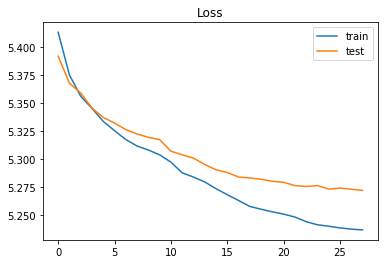

In [191]:
#check the loss
plt.title('Loss')
plt.plot(VGG19_results.history['loss'], label='train')
plt.plot(VGG19_results.history['val_loss'], label='test')
plt.legend()
plt.show()

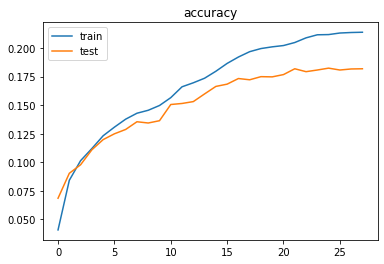

In [192]:
#check the accuracy
plt.title('accuracy')
plt.plot(VGG19_results.history['accuracy'], label='train')
plt.plot(VGG19_results.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [193]:
# check the test accuracy

from sklearn.metrics import accuracy_score 

pred = VGG19.predict(X_test)
pred = pred.argmax(axis=1)
acc = accuracy_score(y_test, pred) 


In [194]:
print('Accuracy is',acc)

Accuracy is 0.18164603058994902
